<center><img src="logo_skmob.png" width=450 align="left" /></center>

# Flow models

- Repo: [http://bit.ly/skmob_repo](http://bit.ly/skmob_repo)
- Docs: [http://bit.ly/skmob_doc](http://bit.ly/skmob_doc)
- Paper: [http://bit.ly/skmob_paper](http://bit.ly/skmob_paper)

## Outline

#### Train a Gravity model in <font color='blue'>San Francisco</font> to predict flows in <font color='blue'>Denver</font>

1. Download checkin data and create a `TrajDataFrame`
1. Create square tessellations for the two cities
1. Compute the relevance of each tile
1. Create `FlowDataFrame`s aggregating `TrajDataFrame`s 

5. Compute the total number of trips from each tile
6. Fit a singly-constrained Gravity using trips in San Francisco
7. Use the fitted model to predict flows in Denver


8. **<font color='blue'>Qualitative evaluation</font>**: visualise the performance of the model against a baseline random model
9. **<font color='blue'>Quantitative evaluation</font>**: compute performance metrics

## Import the libraries

In [1]:
import skmob
from skmob.utils import utils, constants
from skmob.tessellation import tilers
from skmob.utils.plot import plot_gdf

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import folium
from folium.plugins import HeatMap
import matplotlib as mpl
import matplotlib.pyplot as plt

## Create a `TrajDataFrame` from <a href="https://snap.stanford.edu/data/loc-brightkite.html">Brightkite</a> checkins

In [3]:
# first download checkins using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\\t', header=0, nrows=100000, 
                 names=['user', 'check-in_time', 'latitude', 'longitude', 'location id'])

/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [4]:
# convert the DataFrame into a TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', longitude='longitude', datetime='check-in_time', user_id='user')
print('number of rows: %s' %len(tdf))
print(type(tdf))
tdf.head()

number of rows: 100000
<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


uid                  datetime        lat         lng  \
0    0 2010-10-16 06:02:04+00:00  39.891383 -105.070814   
1    0 2010-10-16 03:48:54+00:00  39.891077 -105.068532   
2    0 2010-10-14 18:25:51+00:00  39.750469 -104.999073   
3    0 2010-10-14 00:21:47+00:00  39.752713 -104.996337   
4    0 2010-10-13 23:31:51+00:00  39.752508 -104.996637   

                                location id  
0          7a0f88982aa015062b95e3b4843f9ca2  
1          dd7cd3d264c2d063832db506fba8bf79  
2  9848afcc62e500a01cf6fbf24b797732f8963683  
3          2ef143e12038c870038df53e0478cefc  
4          424eb3dd143292f9e013efa00486c907

## Visualise the trajectory of 10 users


In [5]:
tdf.plot_trajectory(max_users=10, max_points=1000, zoom=4, start_end_markers=False)

## Visualise a heat map of checkin locations


In [6]:
m = folium.Map(tiles = 'openstreetmap', zoom_start=12, control_scale=True)
HeatMap(tdf[:50000][['lat', 'lng']].values).add_to(m)
m

## Create square tessellations

### Train city: San Francisco

In [7]:
# it retrieve information from the web
tess_train = tilers.tiler.get("squared", meters=2500, 
                              base_shape="San Francisco, California")
len(tess_train)

207

### Test city: Denver

In [8]:
tess_test = tilers.tiler.get("squared", meters=2500, 
                             base_shape="Denver, Colorado")
len(tess_test)

158

## Compute the relevance of each tile


1. assign each point to the corresponding tile in San Francisco

In [9]:
tdf_tid = tdf.mapping(tess_train, remove_na=True)
tdf_tid.head(3)

uid                  datetime        lat         lng  \
347    0 2010-05-07 02:46:58+00:00  37.785078 -122.404998   
348    0 2010-05-07 02:43:54+00:00  37.785078 -122.404998   
349    0 2010-05-07 02:12:09+00:00  37.790254 -122.407277   

                                  location id tile_ID  
347  8d788309d5057922a69ea575f8fc4ea7acbab45c     162  
348  8d788309d5057922a69ea575f8fc4ea7acbab45c     162  
349          a53d39a2ef3611dd970d003048c10834     162

2. compute the relevance of each tile in San Francisco

In [10]:
relevances = tdf_tid.groupby(by='tile_ID').count()[['lat']].rename(
    columns={'lat': 'relevance'})
relevances /= relevances.sum() # normalize

tess_train = tess_train.merge(relevances, right_index=True, left_on='tile_ID', how='left').fillna(0.)
tess_train.head(3)

tile_ID                                           geometry  relevance
0       0  POLYGON ((-123.173825 37.72917858254642, -123....        0.0
1       1  POLYGON ((-123.173825 37.74693866076989, -123....        0.0
2       2  POLYGON ((-123.173825 37.76469447796389, -123....        0.0

Do the same for Denver

In [11]:
tdf_tid = tdf.mapping(tess_test, remove_na=True)
relevances = tdf_tid.groupby(by='tile_ID').count()[['lat']].rename(columns={'lat': 'relevance'})
# normalise
relevances /= relevances.sum()

tess_test = tess_test.merge(relevances, right_index=True, left_on='tile_ID', how='left').fillna(0.)
tess_test.head(3)

tile_ID                                           geometry  relevance
0       0  POLYGON ((-105.1098845 39.6143154, -105.109884...    0.00047
1       1  POLYGON ((-105.1098845 39.63161375638285, -105...    0.00000
2       2  POLYGON ((-105.087426617897 39.6143154, -105.0...    0.00000

## Visualise the relevances on a map

In [12]:
def define_colormap(tessellation, minval=1e-6):
    # define the colormap
    normc = mpl.colors.LogNorm(vmin=max(tessellation['relevance'].min(), minval), \
                               vmax=tessellation['relevance'].max())
    s_m = mpl.cm.ScalarMappable(cmap='jet', norm=normc)
    return s_m

def get_color(x):
    return mpl.colors.to_hex(s_m.to_rgba(x['relevance'] + 1e-12))

In [13]:
s_m = define_colormap(tess_train)
plot_gdf(tess_train, zoom=10, popup_features=['relevance'], \
         style_func_args={'color': get_color, 'fillColor' : get_color})

In [14]:
# the same for Denver
s_m = define_colormap(tess_test)
plot_gdf(tess_test, zoom=10, popup_features=['relevance'], \
         style_func_args={'color': get_color, 'fillColor' : get_color})

## Create `FlowDataFrame`s 

In [15]:
# for San Francisco
fdf_train = tdf.to_flowdataframe(tess_train, remove_na=True, self_loops=False)
print(fdf_train['flow'].sum(), fdf_train['flow'].max())
fdf_train.head(4)

2305 177


origin destination  flow
1    111         137     1
2    111         148     1
4    112         137     1
5    112         146     2

In [16]:
# for Denver
fdf_test = tdf.to_flowdataframe(tess_test, remove_na=True, self_loops=False)
print(fdf_test['flow'].sum(), fdf_test['flow'].max())
fdf_test.head()

10627 445


origin destination  flow
1      0         127     1
2      0          34     1
3      0          35     1
4      0           4     1
5      0          43     2

In [17]:
# plot flows in San Francisco
fdf_train.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [18]:
# plot flows in Denver
fdf_test.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

## Compute number of trips from each tile

In [19]:
# total outflows excluding self loops in San Francisco
tot_outflows = fdf_train[fdf_train['origin'] != fdf_train['destination']] \
    .groupby(by='origin', axis=0)[['flow']].sum().fillna(0).rename(columns={'flow': 'tot_outflow'})

if 'tot_outflow' not in tess_train.columns:
    tess_train = tess_train.merge(tot_outflows, right_index=True, left_on='tile_ID', how='left').fillna(0.).sort_values(by='tot_outflow', ascending=False)
tess_train.head()

tile_ID                                           geometry  relevance  \
162     162  POLYGON ((-122.4102570084984 37.78244603344593...   0.277900   
161     161  POLYGON ((-122.4102570084984 37.76469447796389...   0.197956   
147     147  POLYGON ((-122.4327148906014 37.76469447796389...   0.183130   
146     146  POLYGON ((-122.4327148906014 37.74693866076989...   0.076938   
148     148  POLYGON ((-122.4327148906014 37.78244603344593...   0.063715   

     tot_outflow  
162        501.0  
161        471.0  
147        362.0  
146        197.0  
148        177.0

In [20]:
# total outflows excluding self loops in Denver
tot_outflows = fdf_test[fdf_test['origin'] != fdf_test['destination']] \
    .groupby(by='origin', axis=0)[['flow']].sum().fillna(0).rename(columns={'flow': 'tot_outflow'})

if 'tot_outflow' not in tess_test.columns:
    tess_test = tess_test.merge(tot_outflows, right_index=True, left_on='tile_ID', how='left').fillna(0.).sort_values(by='tot_outflow', ascending=False)
tess_test.head()

tile_ID                                           geometry  relevance  \
42      42  POLYGON ((-104.997595089485 39.73531306739469,...   0.226130   
43      43  POLYGON ((-104.997595089485 39.75258114344286,...   0.191771   
34      34  POLYGON ((-105.020052971588 39.73531306739469,...   0.122199   
35      35  POLYGON ((-105.020052971588 39.75258114344286,...   0.061633   
59      59  POLYGON ((-104.9526793252791 39.7007639341009,...   0.026975   

    tot_outflow  
42       1908.0  
43       1686.0  
34       1286.0  
35        773.0  
59        401.0

## Fit a singly-constrained Gravity Model using trips in San Francisco

In [21]:
# import the Gravity class
from skmob.models.gravity import Gravity

The `Gravity` class has two public methods:
- `fit` fits the method parameters from data;
- `generate` generates the flows

### Fit the gravity model's parameters


In [22]:
gravity_singly_fitted = Gravity(gravity_type='singly constrained')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [23]:
gravity_singly_fitted.fit(fdf_train, relevance_column='relevance')
print(gravity_singly_fitted)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.8323557156771302], origin_exp=1.0, destination_exp=0.709313443150735, gravity_type="singly constrained")


## Use the fitted model to predict the flows in Denver

In [25]:
np.random.seed(0)
sc_fdf_fitted = gravity_singly_fitted.generate(tess_test, 
                tile_id_column='tile_ID', 
                tot_outflows_column='tot_outflow', 
                relevance_column= 'relevance', out_format='flows')
sc_fdf_fitted.head(3)

100%|██████████| 158/158 [00:00<00:00, 1941.01it/s]


origin destination  flow
0     42          43   455
1     42          34   339
2     42          35   151

In [26]:
sc_fdf_fitted.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [27]:
denv_map = sc_fdf_fitted.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)
fdf_test.plot_flows(map_f=denv_map, min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25, flow_color='black')

## <font color="blue">Qualitative</font> evaluation
visualise the model's performance against a baseline
### 1. Create a baseline model (without dependence on relevance and distance)

In [28]:
baseline = Gravity(gravity_type='singly constrained', deterrence_func_args=[0.], destination_exp=0.)
print(baseline)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[0.0], origin_exp=1.0, destination_exp=0.0, gravity_type="singly constrained")


In [29]:
np.random.seed(0)
baseline_fdf = baseline.generate(tess_test, 
                                   tile_id_column='tile_ID', 
                                   tot_outflows_column='tot_outflow', 
                                   relevance_column= 'relevance',
                                   out_format='flows')
baseline_fdf[:4]

100%|██████████| 158/158 [00:00<00:00, 1923.60it/s]


origin destination  flow
0     42          42    12
1     42          43    14
2     42          34    13
3     42          35    12

In [30]:
baseline_fdf.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)

In [31]:
denv_base_map = baseline_fdf.plot_flows(min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25)
fdf_test.plot_flows(map_f=denv_base_map, min_flow=5, zoom=10, tiles='cartodbpositron', flow_weight=2, opacity=0.25, flow_color='black')

### Compare real flows against generated flows

In [32]:
xy = fdf_test.merge(sc_fdf_fitted, on=['origin', 'destination'])[['flow_x', 'flow_y']].values
xy_baseline = fdf_test.merge(baseline_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

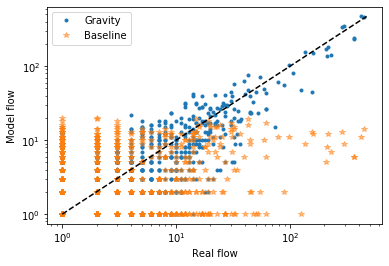

In [34]:
plt.plot(xy[:,0], xy[:,1], '.', label='Gravity')
plt.plot(xy_baseline[:,0], xy_baseline[:,1], '*', alpha=0.5, label='Baseline')
x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')
plt.xlabel('Real flow'); plt.ylabel('Model flow')
plt.legend(loc = 'upper left')
plt.loglog(); plt.show()

## <font color="blue">Quantitative</font> evaluation metrics


In [35]:
from skmob.measures.evaluation import r_squared, mse, spearman_correlation, pearson_correlation, common_part_of_commuters, common_part_of_commuters_distance

In [36]:
metrics = [r_squared, mse, spearman_correlation, pearson_correlation, common_part_of_commuters, common_part_of_commuters_distance]
names = ['r_squared', 'mse', 'spearman_correlation', 'pearson_correlation', 'common_part_of_commuters', 'common_part_of_commuters_distance']

In [37]:
print('Metric:  Gravity - Baseline')
print('---------------------------')
for i, metric in enumerate(metrics):
    m = metric(xy[:, 0], xy[:, 1])
    b = metric(xy_baseline[:, 0], xy_baseline[:, 1])
    print("%s:   %s - %s" % (names[i], np.round(m, 3), np.round(b, 3)))

Metric:  Gravity - Baseline
---------------------------
r_squared:   0.9 - 0.002
mse:   113.344 - 1404.146
spearman_correlation:   [0.662 0.   ] - [0.212 0.   ]
pearson_correlation:   [0.949 0.   ] - [0.202 0.   ]
common_part_of_commuters:   0.81 - 0.609
common_part_of_commuters_distance:   0.09 - 0.081
